In [119]:
import numpy as np
import matplotlib.pyplot as plt


We want to minimize our mystery function, but we can't graph it. We can evaluate the function at different points, and we can also evaluate it's derivative.

Let's try some random values

In [33]:
mystery_func(0)

160072

In [19]:
mystery_func(80)

102712

Okay, this isn't getting us very far, how about we try a random value and evaluate the derivative at that point

In [72]:
val = 500
mystery_func(val), mystery_func_prime(val)

(11572, 203)

This is really getting us somewhere, we can definitely use these results to find the minimum.  

So now can we functionalize this process, make it automatic.

In [106]:
def find_minimum(initial_guess, n_iterations, step_size):
    current_location = initial_guess
    for _ in range(n_iterations):
        current_val = mystery_func(current_location)
        current_slope = mystery_func_prime(current_location)
        if current_slope < 0:
            current_location += step_size
        elif current_slope > 0:
            current_location -= step_size
        else:
            break
    return current_location

In [108]:
initial_guess = np.random.randint(-5000, 5000)
find_minimum(initial_guess, 1000, 10)

390

In [90]:
y = 2*x**2 + 1

In [23]:
yprime = y.diff(x)

In [30]:
yprime

4*x

In [29]:
lambdify(x, yprime)(5)

20

In [ ]:
plt.plot

398.4398439843985

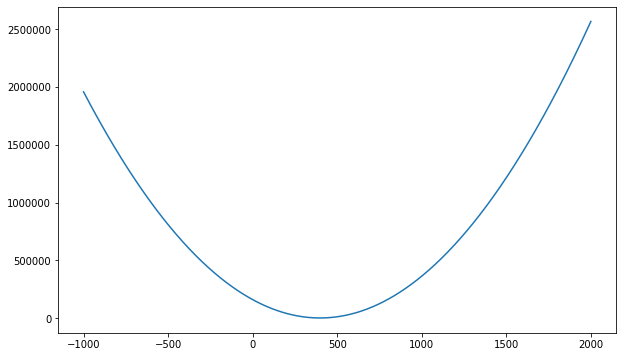

In [43]:
x = np.linspace(-1000, 2000, 10000)
plt.figure(figsize = (10,6))
plt.plot(x, mystery_func(x))
x[np.argmin(mystery_func(x))]